# Why Cross Validation?

* In general the validation set approach (i.e train on a subset of data and test on the remaining data) has the drawback that the error can vary a lot depending on what is and what is not in the training set. This increases the **bias** of the validation set approach
* Also, in general the model ends up getting trained on lesser data, which tends to reduce the performance of models

Cross-Validation tries to address these concerns

In [6]:
library(ISLR)
library(dplyr)
set.seed(2)
train=sample(392,196)

Warning message:
"package 'ISLR' was built under R version 3.3.2"Warning message:
"package 'dplyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [7]:
lm.fit=lm(mpg~horsepower,data=Auto,subset=train)

# Calculate the test MSE
mean((Auto$mpg-predict(lm.fit,Auto))[-train]^2)

[1] 23.29559

Now, try the same thing for Polynomial regressions

In [8]:
lm.fit2=lm(mpg~poly(horsepower,2),data=Auto,subset=train)
mean((Auto$mpg-predict(lm.fit2,Auto))[-train]^2)

lm.fit3=lm(mpg~poly(horsepower,3),data=Auto,subset=train)
mean((Auto$mpg-predict(lm.fit3,Auto))[-train]^2)

[1] 18.90124

[1] 19.2574

# LOOCV

* LOOCV takes the first element as the validation set, with the rest of the data as the training set. It then trains or fits the model on the training set, and validates against the validation set
* And then repeats the process with the second element as the validation set and so on
* This results in a very low bias, as each training set contains almost all the data

LOOCV can be automatically calculated by using the `glm` and `cv.glm` functions.

`glm()` without any "family" arg performs linear regression. Here we'll use `glm` instead of `lm` as that can be later used with `cv.glm()`

`cv.glm` is in the `boot` library

In [9]:
library(boot)
glm.fit=glm(mpg~horsepower,data=Auto)
coef(glm.fit)

(Intercept)  horsepower 
 39.9358610  -0.1578447

`cv.glm` performs cross-validation. It's `delta` vector gives the X-validation results.

$$CV_{(x)} = \frac{1}{n}\sum_{i=1}^n MSE_i$$

The result of cv.glm contains multiple components. The `delta` component is a vector of two: the first element is the raw X-validation estimate of prediction error, the second element is the bias-corrected X-validation estimate. 

Need to understand more what they actually mean

In [10]:
cv.err=cv.glm(Auto,glm.fit)

cv.err$delta

[1] 24.23151 24.23114

Both elements are almost the same.

Let's try LOOC for several polynomial fits (this could take some time). Hint: in notebook mode, the cell shows a [\*] if it is still executing

[1] 24.23151 19.24821 19.33498 19.42443 19.03321

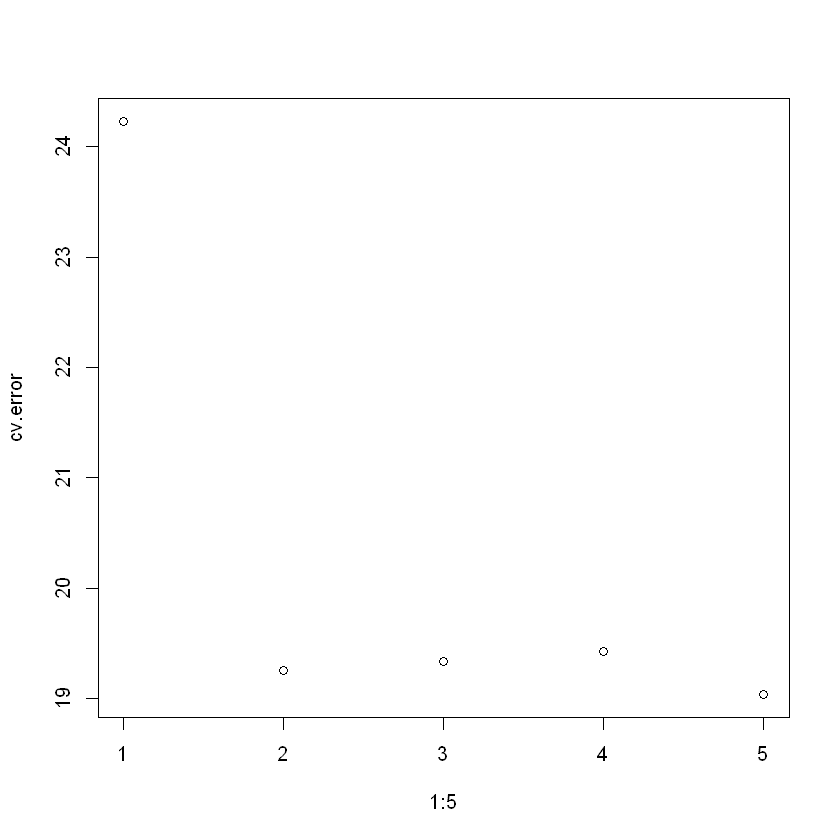

In [11]:
cv.error = rep(0,5)

for(i in 1:5){
    glm.fit=glm(mpg~poly(horsepower,i),data=Auto)
    cv.error[i]=cv.glm(Auto,glm.fit)$delta[1]
}
cv.error
plot(1:5,cv.error)

So there's a sharp drop from order=1(linear) to order=2(quadratic) but not much of a drop after that. So a quad fit would work best

# K-Fold Cross Validation

In K-Fold, the dataset is split randomly into K groups (or folds). Then the first set is taken as the validation set, while the other `k-1` sets are used to fit the model. Then the process is repeated with the second set as the validation set. The CV estimate then is the average of the MSEs for each of the folds

* LOOCV is essentially K-fold, with K=N
* LOOCV requires regression to be performed N times for N predictions
* K-Fold requires regression to be done K times, so there is a computational advantage
* The LOOCV suffers from extremely low bias, and K-Fold will have slightly higher bias (though not as much as simple validation set method)
* LOOCV has a very high variance though. Because LOOCV averages the output of N models, each of which is trained on almost identical datasets. So the outputs have high +ve correlation. The mean of many highly correlated quantities has higher variance than the mean of quantities that aren't highly correlated
* The datasets for K-Fold have lesser +ve correlation

[1] 24.20520 19.18924 19.30662 19.33799 18.87911 19.02103 18.89609 19.71201
 [9] 18.95140 19.50196

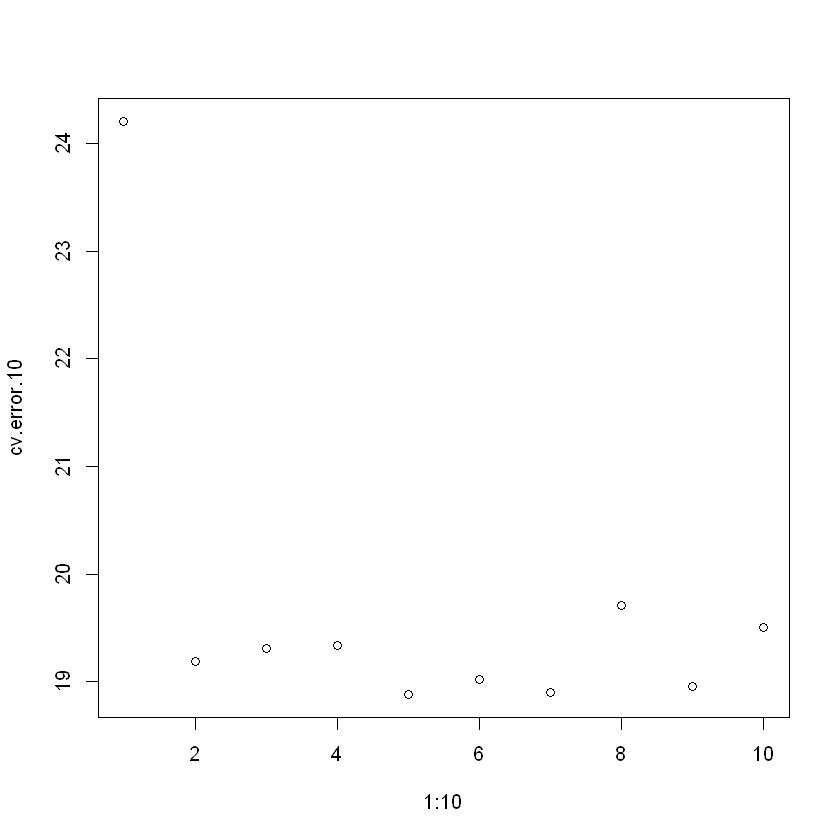

In [12]:
set.seed(17)

cv.error.10=rep(1,10)

for(i in 1:10){
    glm.fit=glm(mpg~poly(horsepower,i),data=Auto)
    cv.error.10[i]=cv.glm(Auto,glm.fit,K=10)$delta[1]
}

cv.error.10
plot(1:10,cv.error.10)

Results are rather similar

# Bootstrap


### Simple Explanation
Consider a dataset `Z` with `n=3` obs. Randomly select `n` observations *with replacement* to produce a bootstrap dataset. So the same obs can occur multiple times in the bootstrap dataset

Let's say $Z=[1,2,3]$

Then some Bootstrap sets could be $Z^{*1} = [1,1,3]$ and $Z^{*2} = [1,3,2]$

Produce B different Bootstrap sets $Z^{*1},Z^{*2},Z^{*3}...Z^{*B}$

Using each set, produce an estimated prediction $\hat{\alpha}^{*1},\hat{\alpha}^{*2},\hat{\alpha}^{*3}...\hat{\alpha}^{*B}$

Then the Std Error is:

$$SE_B(\hat{\alpha}) = \sqrt{ \frac{1}{B-1} \sum_{r=1}^B(\hat{\alpha}^{*r}- \frac{1}{B} \sum_{s=1}^B {\alpha}^{*s} )^2 }$$

### Bootstrap for Linear Reg

Linear Reg equation:

$$horsepower = \beta_0 + \beta_1mpg + \epsilon$$

Using Bootstraps, lets calculate the variability of the estimates for $\beta_0$ and $\beta_1$

First create a function that takes the Auto data, indices for observations and spits out intercept and slope estimates ($\hat{\beta_0}$ and $\hat{\beta_1}$)

In [20]:
boot.fn = function(data,index)
    coef(lm(mpg~horsepower,data=Auto,subset = index))


# Create 1000 data sets by sampling from Auto, apply the boot.fn on that and assess the variability of the results
boot(Auto,boot.fn,1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610  0.0118427139 0.871057282
t2* -0.1578447 -0.0002632441 0.007537443

Indicates that $SE(\hat{\beta_0})=0.871$ and $SE(\hat{\beta_1})=0.008$

Let's also compare that with the Std Errors obtained by `lm` itself

In [21]:
summary(lm(mpg~horsepower,data=Auto))$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),39.9358610,0.717498656,55.65984,1.220362e-187
horsepower,-0.1578447,0.006445501,-24.48914,7.031989e-81


So the Std Errors here (0.717 and 0.006) differ from the Bootstrap errors. However, that isn't a problem with Bootstrap.

The `lm` calculations of Std Error are dependent on the assumptions that
* The data has a linear relationship
* The $x_i$ are fixed, and all variability comes from the $\epsilon_i$ terms

Bootstrap doesn't assume that, so it is likely to be accurate

Let's also try Bootstrap with the quadratic fit, because that has earlier proved to be more accurate

In [23]:
set.seed(1)
boot.fn = function(data,index)
    coef(lm(mpg~horsepower+I(horsepower^2),data=Auto,subset = index))


# Create 1000 data sets by sampling from Auto, apply the boot.fn on that and assess the variability of the results
boot(Auto,boot.fn,1000)
    
summary (lm(mpg∼horsepower +I(horsepower ^2) ,data=Auto))$coef


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
        original        bias     std. error
t1* 56.900099702  6.098115e-03 2.0944855842
t2* -0.466189630 -1.777108e-04 0.0334123802
t3*  0.001230536  1.324315e-06 0.0001208339

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),56.900099702,1.8004268063,31.60367,1.740911e-109
horsepower,-0.466189630,0.0311246171,-14.97816,2.289429e-40
I(horsepower^2),0.001230536,0.0001220759,10.08009,2.196340e-21


### Bootstrap on Portfolio Data

In [13]:
alpha.fn=function(data,index){
    X=data$X[index]
    Y=data$Y[index]
    ((var(Y)-cov (X,Y))/(var(X)+var(Y) -2* cov(X,Y)))
}

alpha.fn(Portfolio,1:100)

[1] 0.5758321

Run a bootstrap with 1000 estimates for $\alpha$

In [18]:
set.seed(1)

boot(Portfolio,alpha.fn,R=1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Portfolio, statistic = alpha.fn, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.5758321 6.936399e-05  0.08868935

So estimation of $\hat{\alpha}=0.5758, SE(\hat{\alpha})=0.0886$